In [1]:
import pandas as pd
import numpy as np

In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from datetime import tzinfo, timedelta, datetime, date

# Data Preparation

In [3]:
orders = pd.read_csv("orders.csv")
# partners = pd.read_csv("partners_delays.csv")

# partners = partners.rename(columns={"dttm" : "date"})
orders['date'] = pd.to_datetime(orders['date'])
# partners['date'] = pd.to_datetime(partners['date'])

In [4]:
id_f = []

start = datetime(2021, 4, 1)
for k in range(593):
  for i in range(244):
    for j in range(7,24):
      id_f.append((k, start + timedelta(days= i, hours=j)))

In [5]:
index_o = pd.MultiIndex.from_tuples([(del_id, date_) for del_id, date_
                                   in zip(orders["delivery_area_id"], orders["date"])],
                                 names=('delivery_area_id', 'date'))



index_f = pd.MultiIndex.from_tuples(id_f,
                                 names=('delivery_area_id', 'date'))



In [6]:
filler_ = pd.DataFrame(index=index_f)
orders_ = pd.DataFrame(np.array(orders['orders_cnt']), index=index_o, columns=['orders_cnt'])

In [7]:
orders_

orders_cnt
delivery_area_id date                           
0                2021-04-01 10:00:00           9
                 2021-04-01 11:00:00           1
                 2021-04-01 13:00:00           1
                 2021-04-01 14:00:00           1
                 2021-04-01 15:00:00           2
...                                          ...
592              2021-11-30 16:00:00           6
                 2021-11-30 17:00:00           3
                 2021-11-30 18:00:00           2
                 2021-11-30 19:00:00           4
                 2021-11-30 20:00:00           4

[884856 rows x 1 columns]

In [8]:
orders_fill = orders_.merge(filler_, left_index = True, right_index= True, how='outer')
orders_fill = orders_fill.fillna(0)
data = orders_fill.reset_index() # заполнены все пропуски

In [9]:
data

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 07:00:00,0.0
1,0,2021-04-01 08:00:00,0.0
2,0,2021-04-01 09:00:00,0.0
3,0,2021-04-01 10:00:00,9.0
4,0,2021-04-01 11:00:00,1.0
...,...,...,...
2459759,592,2021-11-30 19:00:00,4.0
2459760,592,2021-11-30 20:00:00,4.0
2459761,592,2021-11-30 21:00:00,0.0
2459762,592,2021-11-30 22:00:00,0.0


In [10]:
data["orders_cnt"].eq(0).any().any()

True

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459764 entries, 0 to 2459763
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   delivery_area_id  int64         
 1   date              datetime64[ns]
 2   orders_cnt        float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 56.3 MB


In [12]:
data.columns

Index(['delivery_area_id', 'date', 'orders_cnt'], dtype='object')

# Clustering

In [13]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.0 MB/s 


In [14]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans,KShape
from tslearn.clustering import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset

In [15]:
data['date'] = pd.to_datetime(data['date'])

In [16]:
datt = data.set_index('date')
datt = datt['2021-11-01':]

In [17]:
len(datt["delivery_area_id"].unique())

593

In [18]:
df = datt.pivot_table(index='delivery_area_id', columns='date',
                     values = "orders_cnt", aggfunc='first').rename_axis('date').rename_axis(None, axis=1).reset_index(drop=True)
#df = df.rename(columns={'date': 'delivery_area_id'})
#df.set_index('delivery_area_id')
#df = df.fillna(0) # полагаю, что если нет заказов, то данные не вносят, а следовательно получаются пропуски в данных
df

,2021-11-01 07:00:00,2021-11-01 08:00:00,2021-11-01 09:00:00,2021-11-01 10:00:00,2021-11-01 11:00:00,2021-11-01 12:00:00,2021-11-01 13:00:00,2021-11-01 14:00:00,2021-11-01 15:00:00,2021-11-01 16:00:00,...,2021-11-30 14:00:00,2021-11-30 15:00:00,2021-11-30 16:00:00,2021-11-30 17:00:00,2021-11-30 18:00:00,2021-11-30 19:00:00,2021-11-30 20:00:00,2021-11-30 21:00:00,2021-11-30 22:00:00,2021-11-30 23:00:00
0,0.0,0.0,0.0,9.0,8.0,1.0,8.0,7.0,15.0,5.0,...,13.0,13.0,14.0,10.0,21.0,10.0,15.0,5.0,0.0,0.0
1,0.0,0.0,0.0,12.0,20.0,8.0,18.0,15.0,17.0,9.0,...,10.0,12.0,8.0,10.0,14.0,10.0,16.0,5.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,7.0,3.0,9.0,7.0,2.0,6.0,7.0,...,12.0,7.0,9.0,4.0,10.0,9.0,11.0,6.0,0.0,0.0
4,0.0,0.0,0.0,21.0,13.0,16.0,7.0,16.0,11.0,14.0,...,18.0,11.0,12.0,21.0,16.0,24.0,20.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,0.0,0.0,0.0,7.0,7.0,3.0,0.0,6.0,2.0,5.0,...,5.0,0.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,0.0
589,0.0,0.0,0.0,3.0,1.0,2.0,0.0,3.0,1.0,3.0,...,2.0,2.0,1.0,2.0,7.0,3.0,2.0,2.0,0.0,0.0
590,0.0,0.0,0.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,...,1.0,5.0,2.0,4.0,2.0,3.0,2.0,0.0,0.0,0.0
591,0.0,0.0,0.0,4.0,3.0,1.0,0.0,2.0,1.0,2.0,...,8.0,1.0,4.0,1.0,6.0,3.0,6.0,0.0,0.0,0.0


In [19]:
#def missing_values_table(df):
 #   mis_val = df.isnull().sum()
 #   mis_val_percent = 100 * df.isnull().sum() / len(df)
 #   mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
 #   mis_val_table_ren_columns = mis_val_table.rename(
 #   columns = {0 : 'Missing Values', 1 : '% of Total Values'})
 #   mis_val_table_ren_columns = mis_val_table_ren_columns[
 #       mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
 #   '% of Total Values', ascending=False).round(1)
 #   print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
 #       "There are " + str(mis_val_table_ren_columns.shape[0]) +
 #           " columns that have missing values.")
 #   return mis_val_table_ren_columns

In [20]:
#c = missing_values_table(df)
#c

In [21]:
#c["% of Total Values"].unique()

In [22]:
#s = 0
#for i in (c['% of Total Values']):
#  if (i > 60.0):
#    st = c.index[s]
#    del df[st]
# s += 1

In [23]:
X_train = TimeSeriesScalerMinMax().fit_transform(df.iloc[:, 1 :])
X_train = to_time_series_dataset(X_train.copy())

In [24]:
import tensorflow as tf
seed = 1234
np.random.seed(1234)
tf.random.set_seed(1234)


23.521 --> 13.916 --> 13.916 --> 
22.930 --> 12.440 --> 12.324 --> 12.292 --> 12.285 --> 12.276 --> 12.265 --> 12.256 --> 12.251 --> 12.248 --> 
21.437 --> 11.725 --> 11.702 --> 11.701 --> 11.700 --> 11.699 --> 11.699 --> 11.699 --> 
21.374 --> 11.612 --> 11.552 --> 11.546 --> 11.542 --> 11.538 --> 11.536 --> 11.534 --> 11.534 --> 11.533 --> 
20.961 --> 11.502 --> 11.368 --> 11.342 --> 11.326 --> 11.317 --> 11.313 --> 11.310 --> 11.308 --> 11.307 --> 
19.466 --> 11.496 --> 11.335 --> 11.290 --> 11.277 --> 11.273 --> 11.270 --> 11.268 --> 11.267 --> 11.263 --> 
19.336 --> 11.463 --> 11.285 --> 11.223 --> 11.194 --> 11.184 --> 11.178 --> 11.175 --> 11.173 --> 11.172 --> 
17.925 --> 11.380 --> 11.216 --> 11.194 --> 11.175 --> 11.147 --> 11.109 --> 11.073 --> 11.058 --> 11.054 --> 


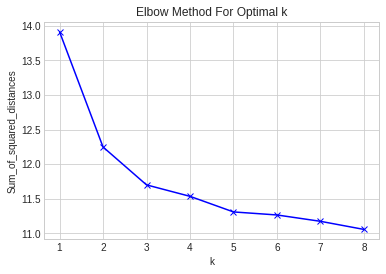

In [25]:
Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=seed,
                         max_iter=10)
    y_pred = km.fit_predict(X_train)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [26]:
colors = ['blue', 'red', 'green']
names = ['blue cluster','red cluster','green cluster']

19.200 --> 11.876 --> 11.769 --> 11.718 --> 11.705 --> 11.700 --> 11.699 --> 11.698 --> 11.697 --> 11.697 --> 
green cluster, N = 297
red cluster, N = 140
blue cluster, N = 156


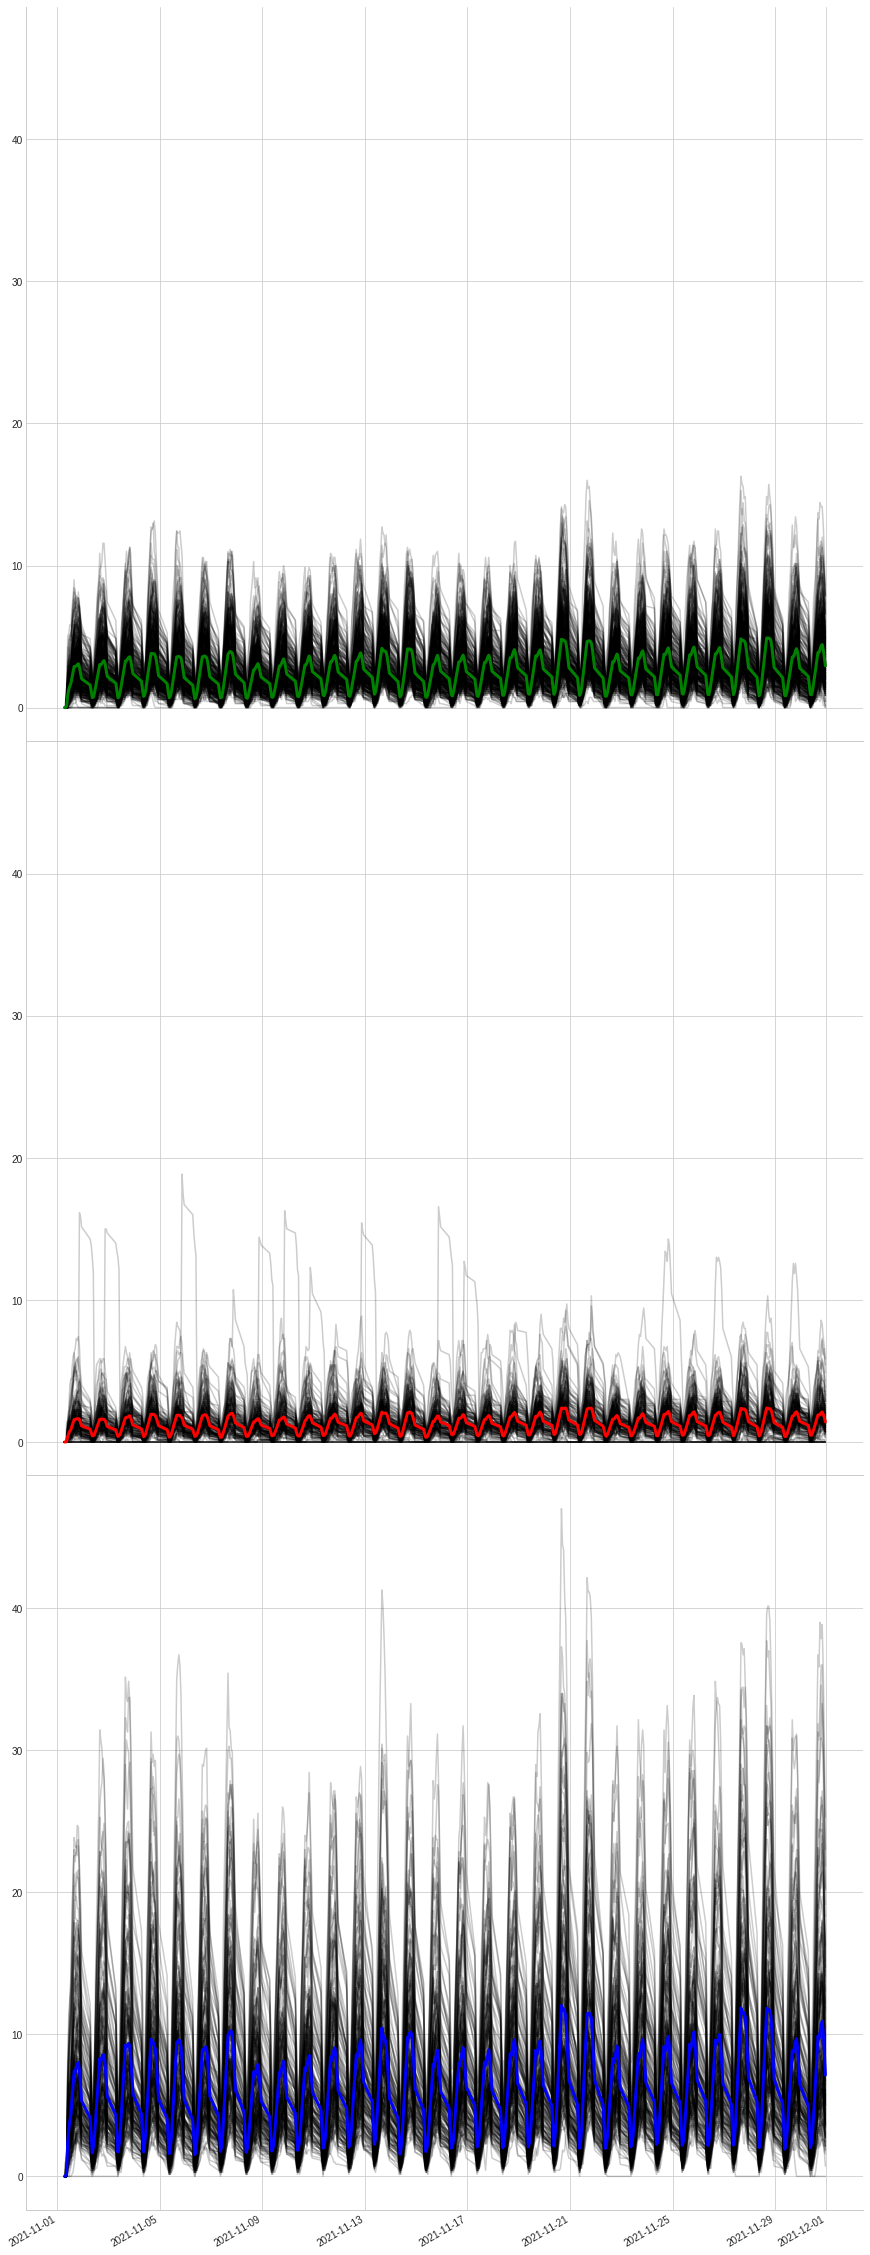

In [27]:
cluster = 3
km = TimeSeriesKMeans(n_clusters=cluster, verbose=True, random_state=1,
                         max_iter=10)

y_pred = km.fit_predict(X_train)
clusters = pd.Series(data=y_pred, index=df.index)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(15, 45))

for yi,cl,xs in zip(range(cluster),[2,1,0],[ax1,ax2,ax3]):
    dat = df.rolling(7, axis=1, min_periods=1).mean().fillna(0).loc[clusters[clusters == cl].index]
    #dat = df.loc[clusters[clusters == cl].index]
    dat.T.plot(legend=False, alpha=.2,color='black', ax=xs)
    dat.mean(axis=0).plot(linewidth=3., color=colors[cl], ax=xs)
    n = len(dat)
    print('{}, N = {}'.format(names[cl], n))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['right'].set_visible(False)

f.subplots_adjust(hspace=0)
#plt.ylim(-0.02, 0.4)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [28]:
len(y_pred)

593

In [29]:
data

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 07:00:00,0.0
1,0,2021-04-01 08:00:00,0.0
2,0,2021-04-01 09:00:00,0.0
3,0,2021-04-01 10:00:00,9.0
4,0,2021-04-01 11:00:00,1.0
...,...,...,...
2459759,592,2021-11-30 19:00:00,4.0
2459760,592,2021-11-30 20:00:00,4.0
2459761,592,2021-11-30 21:00:00,0.0
2459762,592,2021-11-30 22:00:00,0.0


In [30]:
# i-ому элементу y-pred нужно сопоставить i-ую зону доставки из data
clus = []
for i in data["delivery_area_id"]:
  clus.append(y_pred[i])

data.insert(0, "cluster", clus)

In [31]:
data

,cluster,delivery_area_id,date,orders_cnt
0,0,0,2021-04-01 07:00:00,0.0
1,0,0,2021-04-01 08:00:00,0.0
2,0,0,2021-04-01 09:00:00,0.0
3,0,0,2021-04-01 10:00:00,9.0
4,0,0,2021-04-01 11:00:00,1.0
...,...,...,...,...
2459759,1,592,2021-11-30 19:00:00,4.0
2459760,1,592,2021-11-30 20:00:00,4.0
2459761,1,592,2021-11-30 21:00:00,0.0
2459762,1,592,2021-11-30 22:00:00,0.0


# Adding features

In [32]:
mon = []
tue = []
wed = []
thur = []
fri = []
sat = []
sun = []

In [33]:

for d in data["date"]:
  if (d.weekday() == 0) :
    mon.append(1), tue.append(0), wed.append(0), thur.append(0), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 1) :
    mon.append(0), tue.append(1), wed.append(0), thur.append(0), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 2) :
    mon.append(0), tue.append(0), wed.append(1), thur.append(0), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 3) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(1), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 4) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(0), fri.append(1), sat.append(0), sun.append(0)
  if (d.weekday() == 5) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(0), fri.append(0), sat.append(1), sun.append(0)
  if (d.weekday() == 6) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(0), fri.append(0), sat.append(0), sun.append(1)

In [34]:
data.insert(1, "sunday", sun)
data.insert(1, "saturday", sat)
data.insert(1, "friday", fri)
data.insert(1, "thursday", thur)
data.insert(1, "wednesday", wed)
data.insert(1, "tuesday", tue)
data.insert(1, "monday", mon)

In [35]:
data

,cluster,monday,tuesday,wednesday,thursday,friday,saturday,sunday,delivery_area_id,date,orders_cnt
0,0,0,0,0,1,0,0,0,0,2021-04-01 07:00:00,0.0
1,0,0,0,0,1,0,0,0,0,2021-04-01 08:00:00,0.0
2,0,0,0,0,1,0,0,0,0,2021-04-01 09:00:00,0.0
3,0,0,0,0,1,0,0,0,0,2021-04-01 10:00:00,9.0
4,0,0,0,0,1,0,0,0,0,2021-04-01 11:00:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2459759,1,0,1,0,0,0,0,0,592,2021-11-30 19:00:00,4.0
2459760,1,0,1,0,0,0,0,0,592,2021-11-30 20:00:00,4.0
2459761,1,0,1,0,0,0,0,0,592,2021-11-30 21:00:00,0.0
2459762,1,0,1,0,0,0,0,0,592,2021-11-30 22:00:00,0.0


In [36]:
#holiday = [] #  в первую неделю декабря нет праздников
d1 = date(2021, 11, 4)
#for d in data["date"]:
#  if (d.date() == d1) :
#    holiday.append(1)
#  else:
#    holiday.append(0)

In [37]:
#data.insert(2, "holiday", holiday)

In [38]:
#data

In [39]:
month = d.date().strftime('%B')

In [40]:
print(month)

November


In [41]:
#days_before = [] # обучаем на ноябре, поэтому данные только по ноябрю
#for d in data["date"]:
#  if (d.date().strftime("%B") == "November"):
#    if ((d1 - d.date()).days > 0 ) :
#      days_before.append((d1 - d.date()).days)
#    else:
#      days_before.append(0)
#  else:
#    days_before.append(0)

In [42]:
# можно была сразу после кластеризации оставить только ноябрь...

In [43]:
#data.insert(3, "days_before", days_before)
#data

In [44]:
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols] 
data

,orders_cnt,cluster,monday,tuesday,wednesday,thursday,friday,saturday,sunday,delivery_area_id,date
0,0.0,0,0,0,0,1,0,0,0,0,2021-04-01 07:00:00
1,0.0,0,0,0,0,1,0,0,0,0,2021-04-01 08:00:00
2,0.0,0,0,0,0,1,0,0,0,0,2021-04-01 09:00:00
3,9.0,0,0,0,0,1,0,0,0,0,2021-04-01 10:00:00
4,1.0,0,0,0,0,1,0,0,0,0,2021-04-01 11:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2459759,4.0,1,0,1,0,0,0,0,0,592,2021-11-30 19:00:00
2459760,4.0,1,0,1,0,0,0,0,0,592,2021-11-30 20:00:00
2459761,0.0,1,0,1,0,0,0,0,0,592,2021-11-30 21:00:00
2459762,0.0,1,0,1,0,0,0,0,0,592,2021-11-30 22:00:00


In [45]:
data = pd.get_dummies(data, columns=["delivery_area_id"], prefix=["id_"] )# merge with main df bridge_df on key values
#data = data.join(dum_df)
#data
data

,orders_cnt,cluster,monday,tuesday,wednesday,thursday,friday,saturday,sunday,date,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
0,0.0,0,0,0,0,1,0,0,0,2021-04-01 07:00:00,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,1,0,0,0,2021-04-01 08:00:00,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,1,0,0,0,2021-04-01 09:00:00,...,0,0,0,0,0,0,0,0,0,0
3,9.0,0,0,0,0,1,0,0,0,2021-04-01 10:00:00,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,1,0,0,0,2021-04-01 11:00:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459759,4.0,1,0,1,0,0,0,0,0,2021-11-30 19:00:00,...,0,0,0,0,0,0,0,0,0,1
2459760,4.0,1,0,1,0,0,0,0,0,2021-11-30 20:00:00,...,0,0,0,0,0,0,0,0,0,1
2459761,0.0,1,0,1,0,0,0,0,0,2021-11-30 21:00:00,...,0,0,0,0,0,0,0,0,0,1
2459762,0.0,1,0,1,0,0,0,0,0,2021-11-30 22:00:00,...,0,0,0,0,0,0,0,0,0,1


# LSTM

In [46]:
import keras
from keras.layers import Dense
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

## First cluster

In [47]:
data0 = data.loc[data['cluster'] == 0]

del data0["cluster"]
start_date = datetime(2021, 11, 1)
data0 = data0.loc[(data0['date'] >= start_date)]

In [48]:
data0 = data0.set_index('date')
data0

,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,id__0,id__1,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
date,,,,,,,,,,,,,,,,,,,,,
2021-11-01 07:00:00,0.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-01 08:00:00,0.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-01 09:00:00,0.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-01 10:00:00,9.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-01 11:00:00,8.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 19:00:00,11.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-11-30 20:00:00,4.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-11-30 21:00:00,11.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [49]:
df0_1 = data0['2021-11-09' :'2021-11-23']
df0_2 = data0['2021-11-23' :]

In [50]:
df0_2

,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,id__0,id__1,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
date,,,,,,,,,,,,,,,,,,,,,
2021-11-23 07:00:00,0.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-23 08:00:00,0.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-23 09:00:00,0.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-23 10:00:00,7.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-11-23 11:00:00,10.0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 19:00:00,11.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-11-30 20:00:00,4.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-11-30 21:00:00,11.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [51]:
train_values = df0_1.values 
test_values = df0_2.values
# normalize features
scaler0 = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler0.fit_transform(train_values)
test_scaled = scaler0.fit_transform(test_values)

train_X, train_y = train_scaled[:, -600:], train_scaled[:, -601]
test_X, test_y = test_scaled[:, -600:], test_scaled[:, -601]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(39780, 1, 600) (39780,) (21216, 1, 600) (21216,)


In [52]:
from sklearn.metrics import mean_squared_error

Epoch 1/20
10/10 - 6s - loss: 0.0204 - val_loss: 0.0192 - 6s/epoch - 607ms/step
Epoch 2/20
10/10 - 3s - loss: 0.0144 - val_loss: 0.0172 - 3s/epoch - 300ms/step
Epoch 3/20
10/10 - 3s - loss: 0.0126 - val_loss: 0.0165 - 3s/epoch - 298ms/step
Epoch 4/20
10/10 - 3s - loss: 0.0118 - val_loss: 0.0162 - 3s/epoch - 298ms/step
Epoch 5/20
10/10 - 3s - loss: 0.0114 - val_loss: 0.0152 - 3s/epoch - 297ms/step
Epoch 6/20
10/10 - 3s - loss: 0.0110 - val_loss: 0.0147 - 3s/epoch - 298ms/step
Epoch 7/20
10/10 - 3s - loss: 0.0107 - val_loss: 0.0145 - 3s/epoch - 295ms/step
Epoch 8/20
10/10 - 3s - loss: 0.0105 - val_loss: 0.0142 - 3s/epoch - 299ms/step
Epoch 9/20
10/10 - 3s - loss: 0.0103 - val_loss: 0.0140 - 3s/epoch - 300ms/step
Epoch 10/20
10/10 - 3s - loss: 0.0102 - val_loss: 0.0139 - 3s/epoch - 298ms/step
Epoch 11/20
10/10 - 3s - loss: 0.0102 - val_loss: 0.0138 - 3s/epoch - 298ms/step
Epoch 12/20
10/10 - 3s - loss: 0.0101 - val_loss: 0.0137 - 3s/epoch - 297ms/step
Epoch 13/20
10/10 - 3s - loss: 0.0101

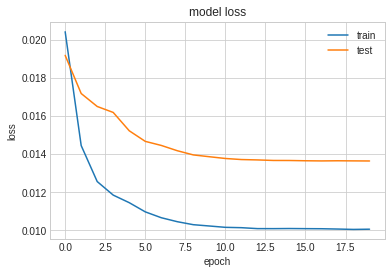

In [53]:
model0 = Sequential()
model0.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model0.add(Dropout(0.2))

model0.add(Dense(1))
model0.compile(loss='mean_squared_error', optimizer='adam')



# fit network

batch_size = 4000

history = model0.fit(train_X, train_y, epochs=20, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [54]:
#prediction
yhat = model0.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 600))

# invert scaling for forecast

inv_yhat = np.concatenate((yhat, test_X[:, -600:]), axis=1)
inv_yhat = scaler0.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

for i in range(len(inv_yhat)):
  inv_yhat[i] = round(inv_yhat[i])
# invert scaling for actual

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -600:]), axis=1)
inv_y = scaler0.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.312


In [55]:
inv_y

array([ 0.,  0.,  0., ..., 11.,  0.,  0.])

In [56]:
inv_yhat

array([6., 6., 6., ..., 4., 4., 4.])

## Second cluster

In [57]:
data1 = data.loc[data['cluster'] == 1]
del data1["cluster"]
data1 = data1.loc[(data1['date'] >= start_date)]
data1 = data1.set_index('date')

df1_1 = data1['2021-11-09' :'2021-11-23']
df1_2 = data1['2021-11-23' :]

train_values = df1_1.values 
test_values = df1_2.values
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler1.fit_transform(train_values)
test_scaled = scaler1.fit_transform(test_values)

train_X, train_y = train_scaled[:, -600:], train_scaled[:, -601]
test_X, test_y = test_scaled[:, -600:], test_scaled[:, -601]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(35700, 1, 600) (35700,) (19040, 1, 600) (19040,)


Epoch 1/20
18/18 - 3s - loss: 0.0017 - val_loss: 0.0102 - 3s/epoch - 172ms/step
Epoch 2/20
18/18 - 0s - loss: 0.0011 - val_loss: 0.0105 - 316ms/epoch - 18ms/step
Epoch 3/20
18/18 - 0s - loss: 8.6458e-04 - val_loss: 0.0101 - 308ms/epoch - 17ms/step
Epoch 4/20
18/18 - 0s - loss: 7.7273e-04 - val_loss: 0.0101 - 320ms/epoch - 18ms/step
Epoch 5/20
18/18 - 0s - loss: 7.0572e-04 - val_loss: 0.0099 - 325ms/epoch - 18ms/step
Epoch 6/20
18/18 - 0s - loss: 6.6794e-04 - val_loss: 0.0099 - 320ms/epoch - 18ms/step
Epoch 7/20
18/18 - 0s - loss: 6.2795e-04 - val_loss: 0.0098 - 321ms/epoch - 18ms/step
Epoch 8/20
18/18 - 0s - loss: 6.0338e-04 - val_loss: 0.0098 - 315ms/epoch - 18ms/step
Epoch 9/20
18/18 - 0s - loss: 5.8372e-04 - val_loss: 0.0098 - 322ms/epoch - 18ms/step
Epoch 10/20
18/18 - 0s - loss: 5.6739e-04 - val_loss: 0.0098 - 326ms/epoch - 18ms/step
Epoch 11/20
18/18 - 0s - loss: 5.5839e-04 - val_loss: 0.0098 - 322ms/epoch - 18ms/step
Epoch 12/20
18/18 - 0s - loss: 5.4459e-04 - val_loss: 0.0098 -

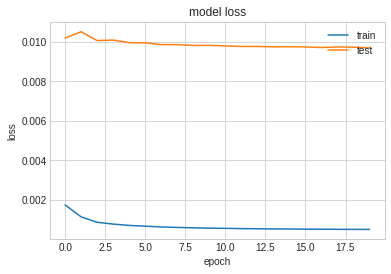

In [58]:
model1 = Sequential()
model1.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model1.add(Dropout(0.2))

model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')



# fit network

batch_size = 2000

history = model1.fit(train_X, train_y, epochs=20, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [59]:
#prediction
yhat = model1.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 600))

# invert scaling for forecast

inv_yhat = np.concatenate((yhat, test_X[:, -600:]), axis=1)
inv_yhat = scaler1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
for i in range(len(inv_yhat)):
  inv_yhat[i] = round(inv_yhat[i])
# invert scaling for actual

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -600:]), axis=1)
inv_y = scaler1.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.265


In [60]:
inv_yhat

array([0., 0., 0., ..., 1., 1., 1.])

## Third cluster

In [61]:
data2 = data.loc[data['cluster'] == 2]
del data2["cluster"]

data2 = data2.loc[(data2['date'] >= start_date)]
data2 = data2.set_index('date')

df2_1 = data2['2021-11-09' :'2021-11-23']
df2_2 = data2['2021-11-23' :]

train_values = df2_1.values 
test_values = df2_2.values
# normalize features
scaler2 = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler2.fit_transform(train_values)
test_scaled = scaler2.fit_transform(test_values)

train_X, train_y = train_scaled[:, -600:], train_scaled[:, -601]
test_X, test_y = test_scaled[:, -600:], test_scaled[:, -601]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(75735, 1, 600) (75735,) (40392, 1, 600) (40392,)


Epoch 1/20
22/22 - 3s - loss: 0.0126 - val_loss: 0.0113 - 3s/epoch - 157ms/step
Epoch 2/20
22/22 - 1s - loss: 0.0092 - val_loss: 0.0101 - 665ms/epoch - 30ms/step
Epoch 3/20
22/22 - 1s - loss: 0.0086 - val_loss: 0.0099 - 663ms/epoch - 30ms/step
Epoch 4/20
22/22 - 1s - loss: 0.0083 - val_loss: 0.0096 - 650ms/epoch - 30ms/step
Epoch 5/20
22/22 - 1s - loss: 0.0081 - val_loss: 0.0095 - 686ms/epoch - 31ms/step
Epoch 6/20
22/22 - 1s - loss: 0.0079 - val_loss: 0.0093 - 687ms/epoch - 31ms/step
Epoch 7/20
22/22 - 1s - loss: 0.0078 - val_loss: 0.0092 - 653ms/epoch - 30ms/step
Epoch 8/20
22/22 - 1s - loss: 0.0077 - val_loss: 0.0091 - 682ms/epoch - 31ms/step
Epoch 9/20
22/22 - 1s - loss: 0.0076 - val_loss: 0.0090 - 689ms/epoch - 31ms/step
Epoch 10/20
22/22 - 1s - loss: 0.0075 - val_loss: 0.0089 - 684ms/epoch - 31ms/step
Epoch 11/20
22/22 - 1s - loss: 0.0074 - val_loss: 0.0088 - 686ms/epoch - 31ms/step
Epoch 12/20
22/22 - 1s - loss: 0.0074 - val_loss: 0.0088 - 683ms/epoch - 31ms/step
Epoch 13/20
22/

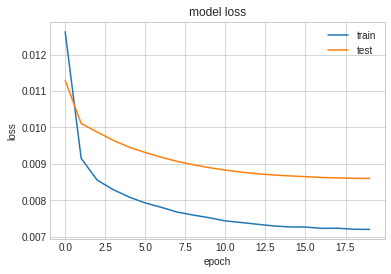

In [62]:
model2 = Sequential()
model2.add(LSTM(14, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.2))

model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')



# fit network

batch_size = 3500

history = model2.fit(train_X, train_y, epochs=20, batch_size=batch_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [63]:
#prediction
yhat = model2.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 600))

# invert scaling for forecast

inv_yhat = np.concatenate((yhat, test_X[:, -600:]), axis=1)
inv_yhat = scaler2.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
for i in range(len(inv_yhat)):
  inv_yhat[i] = round(inv_yhat[i])
# invert scaling for actual

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -600:]), axis=1)
inv_y = scaler2.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.891


In [64]:
inv_yhat

array([3., 3., 3., ..., 2., 2., 2.])

# Prediction

In [65]:
id_ans = []

start = datetime(2021, 12, 1)
for k in range(593):
  for i in range(7):
    for j in range(7,24):
      id_ans.append((k, start + timedelta(days=i,hours=j)))


In [66]:
index_ans = pd.MultiIndex.from_tuples(id_ans,
                                 names=('delivery_area_id', 'date'))

In [67]:
orders_ans = pd.DataFrame( np.empty(len(id_ans)).fill(np.nan), index=index_ans, columns=["orders_cnt"])

In [68]:
orders_ans = orders_ans.reset_index() # готовая таблица для предсказаний

In [69]:
orders_ans 

,delivery_area_id,date,orders_cnt
0,0,2021-12-01 07:00:00,NaN
1,0,2021-12-01 08:00:00,NaN
2,0,2021-12-01 09:00:00,NaN
3,0,2021-12-01 10:00:00,NaN
4,0,2021-12-01 11:00:00,NaN
...,...,...,...
70562,592,2021-12-07 19:00:00,NaN
70563,592,2021-12-07 20:00:00,NaN
70564,592,2021-12-07 21:00:00,NaN
70565,592,2021-12-07 22:00:00,NaN


In [70]:
mon = []
tue = []
wed = []
thur = []
fri = []
sat = []
sun = []

In [71]:
for d in orders_ans["date"]:
  if (d.weekday() == 0) :
    mon.append(1), tue.append(0), wed.append(0), thur.append(0), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 1) :
    mon.append(0), tue.append(1), wed.append(0), thur.append(0), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 2) :
    mon.append(0), tue.append(0), wed.append(1), thur.append(0), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 3) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(1), fri.append(0), sat.append(0), sun.append(0)
  if (d.weekday() == 4) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(0), fri.append(1), sat.append(0), sun.append(0)
  if (d.weekday() == 5) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(0), fri.append(0), sat.append(1), sun.append(0)
  if (d.weekday() == 6) :
    mon.append(0), tue.append(0), wed.append(0), thur.append(0), fri.append(0), sat.append(0), sun.append(1)

In [72]:
orders_ans.insert(1, "sunday", sun)
orders_ans.insert(1, "saturday", sat)
orders_ans.insert(1, "friday", fri)
orders_ans.insert(1, "thursday", thur)
orders_ans.insert(1, "wednesday", wed)
orders_ans.insert(1, "tuesday", tue)
orders_ans.insert(1, "monday", mon)

In [73]:
clus = []
for i in orders_ans["delivery_area_id"]:
  clus.append(y_pred[i])

orders_ans.insert(0, "cluster", clus)

In [74]:
orders_ans

,cluster,delivery_area_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,date,orders_cnt
0,0,0,0,0,1,0,0,0,0,2021-12-01 07:00:00,NaN
1,0,0,0,0,1,0,0,0,0,2021-12-01 08:00:00,NaN
2,0,0,0,0,1,0,0,0,0,2021-12-01 09:00:00,NaN
3,0,0,0,0,1,0,0,0,0,2021-12-01 10:00:00,NaN
4,0,0,0,0,1,0,0,0,0,2021-12-01 11:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...
70562,1,592,0,1,0,0,0,0,0,2021-12-07 19:00:00,NaN
70563,1,592,0,1,0,0,0,0,0,2021-12-07 20:00:00,NaN
70564,1,592,0,1,0,0,0,0,0,2021-12-07 21:00:00,NaN
70565,1,592,0,1,0,0,0,0,0,2021-12-07 22:00:00,NaN


In [75]:
cols = orders_ans.columns.tolist()
cols = [cols[0]] + [cols[-1]] + cols[2:-1] + [cols[1]] 
orders_ans = orders_ans[cols] 
orders_ans


,cluster,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,date,delivery_area_id
0,0,NaN,0,0,1,0,0,0,0,2021-12-01 07:00:00,0
1,0,NaN,0,0,1,0,0,0,0,2021-12-01 08:00:00,0
2,0,NaN,0,0,1,0,0,0,0,2021-12-01 09:00:00,0
3,0,NaN,0,0,1,0,0,0,0,2021-12-01 10:00:00,0
4,0,NaN,0,0,1,0,0,0,0,2021-12-01 11:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
70562,1,NaN,0,1,0,0,0,0,0,2021-12-07 19:00:00,592
70563,1,NaN,0,1,0,0,0,0,0,2021-12-07 20:00:00,592
70564,1,NaN,0,1,0,0,0,0,0,2021-12-07 21:00:00,592
70565,1,NaN,0,1,0,0,0,0,0,2021-12-07 22:00:00,592


In [76]:
orders_ans = pd.get_dummies(orders_ans, columns=["delivery_area_id"], prefix=["id_"] )# merge with main df bridge_df on key values
#data = data.join(dum_df)
#data
orders_ans

,cluster,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,date,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
0,0,NaN,0,0,1,0,0,0,0,2021-12-01 07:00:00,...,0,0,0,0,0,0,0,0,0,0
1,0,NaN,0,0,1,0,0,0,0,2021-12-01 08:00:00,...,0,0,0,0,0,0,0,0,0,0
2,0,NaN,0,0,1,0,0,0,0,2021-12-01 09:00:00,...,0,0,0,0,0,0,0,0,0,0
3,0,NaN,0,0,1,0,0,0,0,2021-12-01 10:00:00,...,0,0,0,0,0,0,0,0,0,0
4,0,NaN,0,0,1,0,0,0,0,2021-12-01 11:00:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70562,1,NaN,0,1,0,0,0,0,0,2021-12-07 19:00:00,...,0,0,0,0,0,0,0,0,0,1
70563,1,NaN,0,1,0,0,0,0,0,2021-12-07 20:00:00,...,0,0,0,0,0,0,0,0,0,1
70564,1,NaN,0,1,0,0,0,0,0,2021-12-07 21:00:00,...,0,0,0,0,0,0,0,0,0,1
70565,1,NaN,0,1,0,0,0,0,0,2021-12-07 22:00:00,...,0,0,0,0,0,0,0,0,0,1


## First cluster

In [77]:
ans0 = orders_ans.loc[orders_ans['cluster'] == 0]
del ans0["cluster"]
ans0 = ans0.loc[(ans0['date'] >= start_date)]
ans0 = ans0.set_index('date')

values = ans0.values 

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

X_0 = scaled[:, -600:]

X_0 = X_0.reshape((X_0.shape[0], 1, X_0.shape[1]))

print(X_0.shape) 

(18564, 1, 600)


In [78]:
ans0

,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,id__0,id__1,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00,NaN,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 08:00:00,NaN,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 09:00:00,NaN,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 10:00:00,NaN,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 11:00:00,NaN,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 19:00:00,NaN,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-12-07 20:00:00,NaN,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-12-07 21:00:00,NaN,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [79]:
#prediction

yhat = model0.predict(X_0)
X_0 = X_0.reshape((X_0.shape[0], 600))

# invert scaling for forecast

inv_yhat0 = np.concatenate((yhat, X_0[:, -600:]), axis=1)
inv_yhat0 = scaler0.inverse_transform(inv_yhat0)
inv_yhat0 = inv_yhat0[:,0]
for i in range(len(inv_yhat0)):
  inv_yhat0[i] = round(inv_yhat0[i])

In [80]:
inv_yhat0 # ответ для 1 кластера

array([6., 6., 6., ..., 4., 4., 4.])

## Second cluster

In [81]:
ans1 = orders_ans.loc[orders_ans['cluster'] == 1]
del ans1["cluster"]
ans1 = ans1.loc[(ans1['date'] >= start_date)]
ans1 = ans1.set_index('date')

values = ans1.values 

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

X_1 = scaled[:, -600:]

X_1 = X_1.reshape((X_1.shape[0], 1, X_1.shape[1]))

print(X_1.shape) 

(16660, 1, 600)


In [82]:
#prediction

yhat = model1.predict(X_1)
X_1 = X_1.reshape((X_1.shape[0], 600))

# invert scaling for forecast

inv_yhat1 = np.concatenate((yhat, X_1[:, -600:]), axis=1)
inv_yhat1 = scaler1.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
for i in range(len(inv_yhat1)):
  inv_yhat1[i] = round(inv_yhat1[i])

In [83]:
inv_yhat1 # ответ для второго кластера 

array([0., 0., 0., ..., 1., 1., 1.])

## Third cluster

In [84]:
ans2 = orders_ans.loc[orders_ans['cluster'] == 2]
del ans2["cluster"]
ans2 = ans2.loc[(ans2['date'] >= start_date)]
ans2 = ans2.set_index('date')

values = ans2.values 

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

X_2 = scaled[:, -600:]

X_2 = X_2.reshape((X_2.shape[0], 1, X_2.shape[1]))

print(X_2.shape) 

(35343, 1, 600)


In [85]:
#prediction

yhat = model2.predict(X_2)
X_2 = X_2.reshape((X_2.shape[0], 600))

# invert scaling for forecast

inv_yhat2 = np.concatenate((yhat, X_2[:, -600:]), axis=1)
inv_yhat2 = scaler2.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]
for i in range(len(inv_yhat2)):
  inv_yhat2[i] = round(inv_yhat2[i])

In [86]:
inv_yhat2 # ответ для ыторого кластера 

array([3., 3., 3., ..., 2., 2., 2.])

#Answers

In [87]:
ans0["orders_cnt"] = inv_yhat0

In [88]:
ans0

,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,id__0,id__1,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00,6.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 08:00:00,6.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 09:00:00,6.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 10:00:00,6.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 11:00:00,6.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 19:00:00,4.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-12-07 20:00:00,4.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2021-12-07 21:00:00,4.0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [89]:
ans1["orders_cnt"] = inv_yhat1

In [90]:
ans1

,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,id__0,id__1,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 08:00:00,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 09:00:00,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 10:00:00,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 11:00:00,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 19:00:00,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2021-12-07 20:00:00,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2021-12-07 21:00:00,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [91]:
ans2["orders_cnt"] = inv_yhat2

In [92]:
ans2

,orders_cnt,monday,tuesday,wednesday,thursday,friday,saturday,sunday,id__0,id__1,...,id__583,id__584,id__585,id__586,id__587,id__588,id__589,id__590,id__591,id__592
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 08:00:00,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 09:00:00,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 10:00:00,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-12-01 11:00:00,3.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07 19:00:00,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2021-12-07 20:00:00,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2021-12-07 21:00:00,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [94]:
ans0.to_csv('ans0.csv')
ans1.to_csv('ans1.csv')
ans2.to_csv('ans2.csv')